In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

resultsPath = Path("../results/MPI_5.csv")


In [8]:
dataFrame = pd.read_csv(resultsPath)
dataFrame["messageSizeBytes"] = dataFrame["messageSizeBytes"].astype(int)
dataFrame["numMessages"] = dataFrame["numMessages"].astype(int)
dataFrame["computeMicroseconds"] = dataFrame["computeMicroseconds"].astype(int)
dataFrame["numIterations"] = dataFrame["numIterations"].astype(int)
dataFrame["numProcesses"] = dataFrame["numProcesses"].astype(int)
dataFrame["totalTimeSeconds"] = dataFrame["totalTimeSeconds"].astype(float)
dataFrame["avgTimePerIteration"] = dataFrame["avgTimePerIteration"].astype(float)
dataFrame["bandwidthBytesPerSec"] = dataFrame["bandwidthBytesPerSec"].astype(float)
dataFrame["runIndex"] = dataFrame["runIndex"].astype(int)

print("Loaded rows:", len(dataFrame))
print("Message sizes:", sorted(dataFrame["messageSizeBytes"].unique()))
print("NumMessages:", sorted(dataFrame["numMessages"].unique()))
print("Compute microseconds:", sorted(dataFrame["computeMicroseconds"].unique()))
print("Process counts:", sorted(dataFrame["numProcesses"].unique()))
dataFrame.head(8)


Loaded rows: 1200
Message sizes: [1, 64, 1024, 65536, 262144]
NumMessages: [1, 4, 16, 32]
Compute microseconds: [10, 50, 100]
Process counts: [2, 4, 6, 8]


,testType,messageSizeBytes,numMessages,computeMicroseconds,numIterations,numProcesses,totalTimeSeconds,avgTimePerIteration,bandwidthBytesPerSec,runIndex,mpiEnv
0,MPI_5,1,1,10,2000,2,0.135336,0.000068,14778.064,1,SLURM_NTASKS=2;JOBID=13360
1,MPI_5,1,1,10,2000,2,0.133918,0.000067,14934.461,2,SLURM_NTASKS=2;JOBID=13361
2,MPI_5,1,1,10,2000,2,0.133964,0.000067,14929.367,3,SLURM_NTASKS=2;JOBID=13362
3,MPI_5,1,1,10,2000,2,0.133996,0.000067,14925.804,4,SLURM_NTASKS=2;JOBID=13363
4,MPI_5,1,1,10,2000,4,0.140571,0.000070,14227.723,3,SLURM_NTASKS=4;JOBID=13367
5,MPI_5,1,1,10,2000,2,0.134787,0.000067,14838.194,5,SLURM_NTASKS=2;JOBID=13364
6,MPI_5,1,1,10,2000,4,0.143068,0.000072,13979.373,1,SLURM_NTASKS=4;JOBID=13365
7,MPI_5,1,1,10,2000,4,0.140507,0.000070,14234.196,4,SLURM_NTASKS=4;JOBID=13368


In [9]:
groupedFrame = dataFrame.groupby(["messageSizeBytes","numMessages","computeMicroseconds","numProcesses"], as_index=False).agg(
    median=("totalTimeSeconds","median"),
    mean=("totalTimeSeconds","mean"),
    std=("totalTimeSeconds","std"),
    count=("totalTimeSeconds","count"),
    medianAvgIter=("avgTimePerIteration","median"),
    medianBandwidth=("bandwidthBytesPerSec","median")
)
groupedFrame["std"] = groupedFrame["std"].fillna(0.0)
groupedFrame = groupedFrame.sort_values(["computeMicroseconds","numMessages","messageSizeBytes","numProcesses"]).reset_index(drop=True)
groupedFrame.head(12)


,messageSizeBytes,numMessages,computeMicroseconds,numProcesses,median,mean,std,count,medianAvgIter,medianBandwidth
0,1,1,10,2,0.133996,0.134400,0.000635,5,0.000067,1.492580e+04
1,1,1,10,4,0.140507,0.139252,0.003367,5,0.000070,1.423420e+04
2,1,1,10,6,0.144182,0.143796,0.002033,5,0.000072,1.387136e+04
3,1,1,10,8,0.142397,0.142741,0.001787,5,0.000071,1.404526e+04
4,64,1,10,2,0.134154,0.134130,0.000442,5,0.000067,9.541253e+05
5,64,1,10,4,0.140687,0.140612,0.002357,5,0.000070,9.098231e+05
6,64,1,10,6,0.141247,0.143024,0.003930,5,0.000071,9.062116e+05
7,64,1,10,8,0.144041,0.145325,0.004252,5,0.000072,8.886387e+05
8,1024,1,10,2,0.068236,0.068249,0.000076,5,0.000068,1.500683e+07
9,1024,1,10,4,0.071070,0.071285,0.002470,5,0.000071,1.440832e+07


In [10]:
def computeSpeedupEfficiency(groupedDf):
    frames = []
    groupKeys = ["messageSizeBytes","numMessages","computeMicroseconds"]
    for keys, sub in groupedDf.groupby(groupKeys):
        baseRows = sub[sub["numProcesses"] == 2]
        if baseRows.empty:
            continue
        baseTime = float(baseRows["median"].values[0])
        subFrame = sub.copy()
        subFrame["speedup"] = baseTime / subFrame["median"]
        subFrame["efficiency"] = subFrame["speedup"] / subFrame["numProcesses"]
        frames.append(subFrame)
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, ignore_index=True)

perfFrame = computeSpeedupEfficiency(groupedFrame)
perfFrame.head(12)


,messageSizeBytes,numMessages,computeMicroseconds,numProcesses,median,mean,std,count,medianAvgIter,medianBandwidth,speedup,efficiency
0,1,1,10,2,0.133996,0.134400,0.000635,5,0.000067,14925.804,1.000000,0.500000
1,1,1,10,4,0.140507,0.139252,0.003367,5,0.000070,14234.196,0.953661,0.238415
2,1,1,10,6,0.144182,0.143796,0.002033,5,0.000072,13871.357,0.929353,0.154892
3,1,1,10,8,0.142397,0.142741,0.001787,5,0.000071,14045.257,0.941003,0.117625
4,1,1,50,2,0.319689,0.326144,0.015503,5,0.000160,6256.089,1.000000,0.500000
5,1,1,50,4,0.345229,0.345011,0.006415,5,0.000173,5793.250,0.926020,0.231505
6,1,1,50,6,0.356100,0.355300,0.006692,5,0.000178,5616.393,0.897751,0.149625
7,1,1,50,8,0.369912,0.370471,0.016768,5,0.000185,5406.697,0.864230,0.108029
8,1,1,100,2,0.421174,0.426497,0.013107,5,0.000211,4748.633,1.000000,0.500000
9,1,1,100,4,0.439091,0.449451,0.015980,5,0.000220,4554.860,0.959195,0.239799


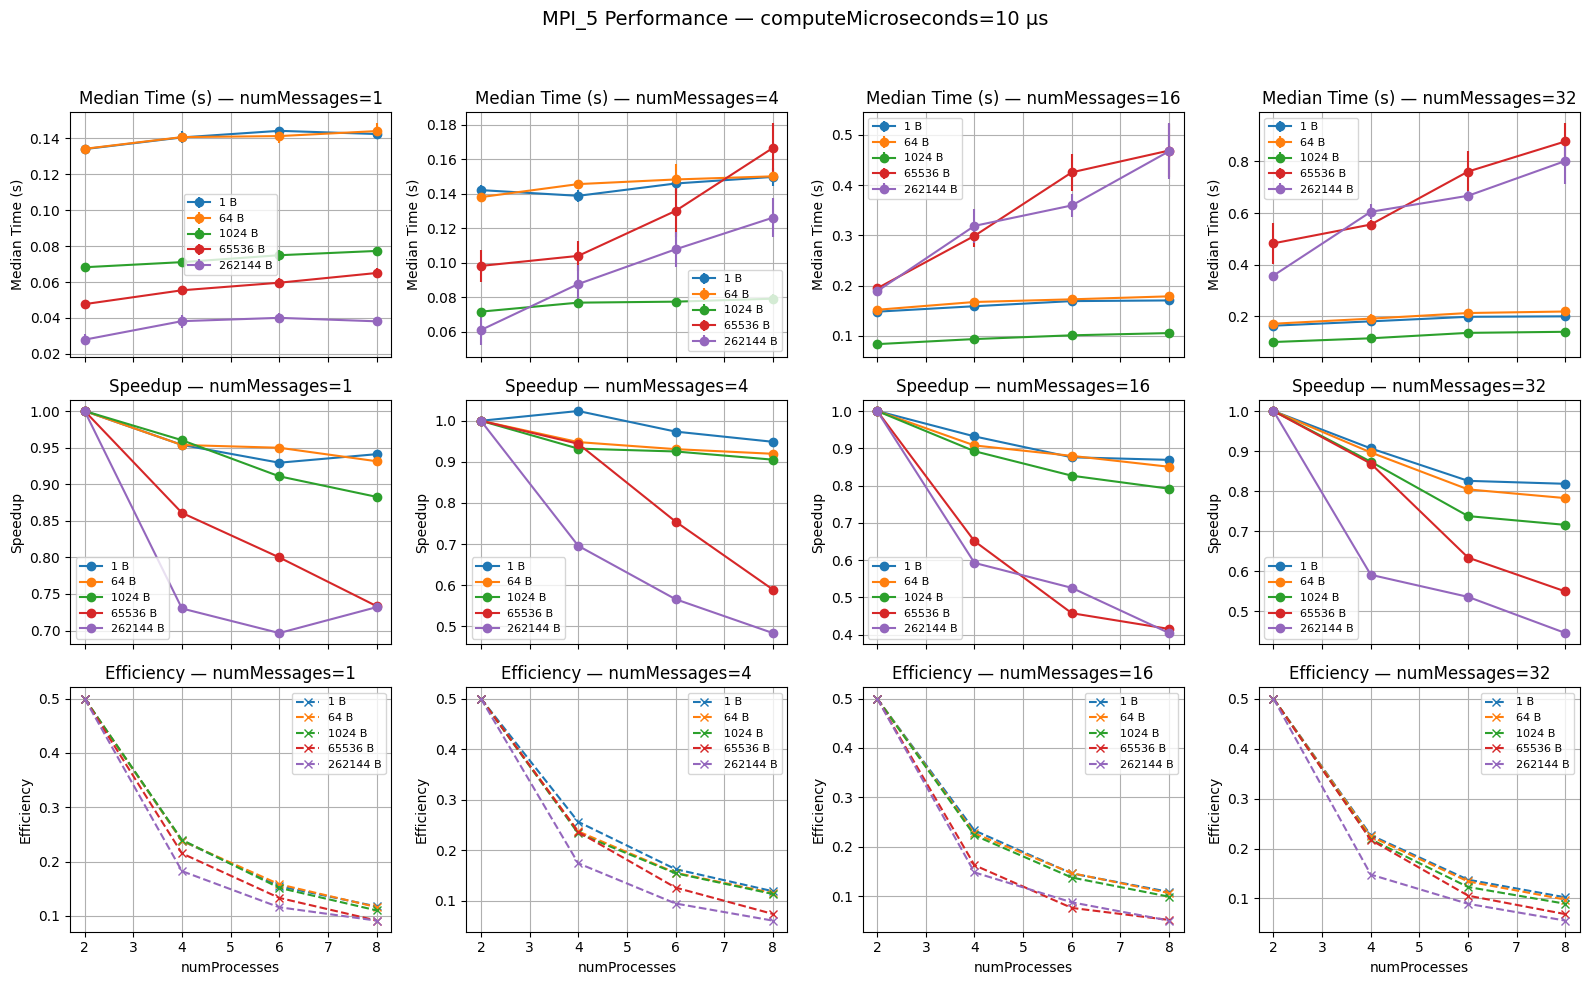

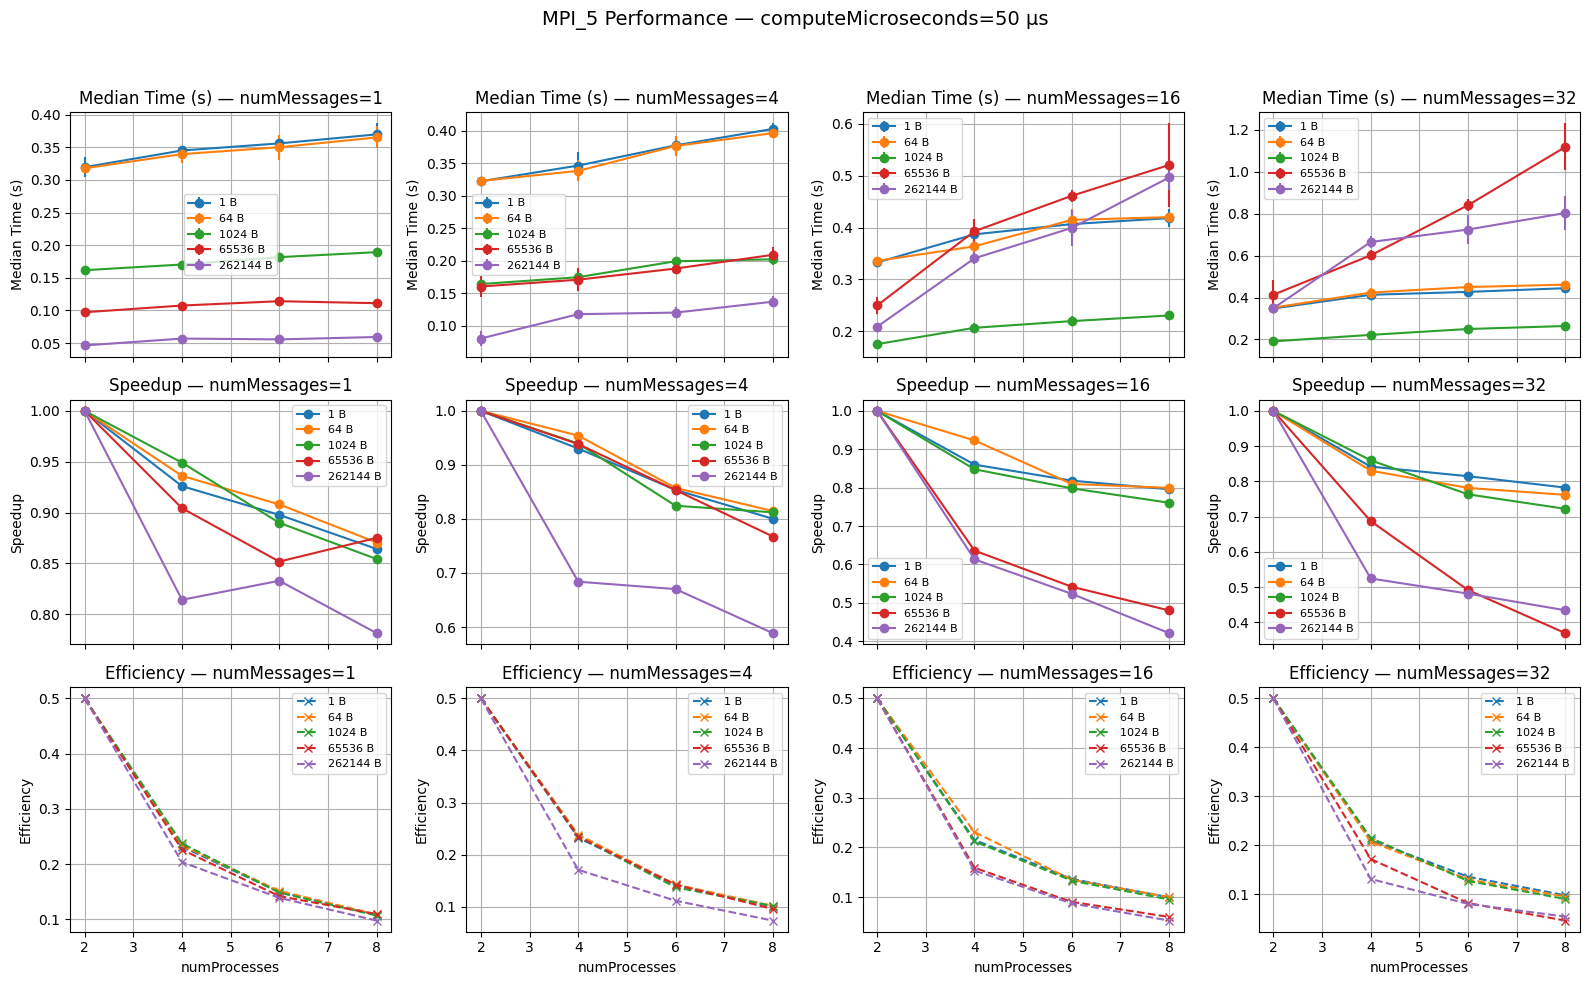

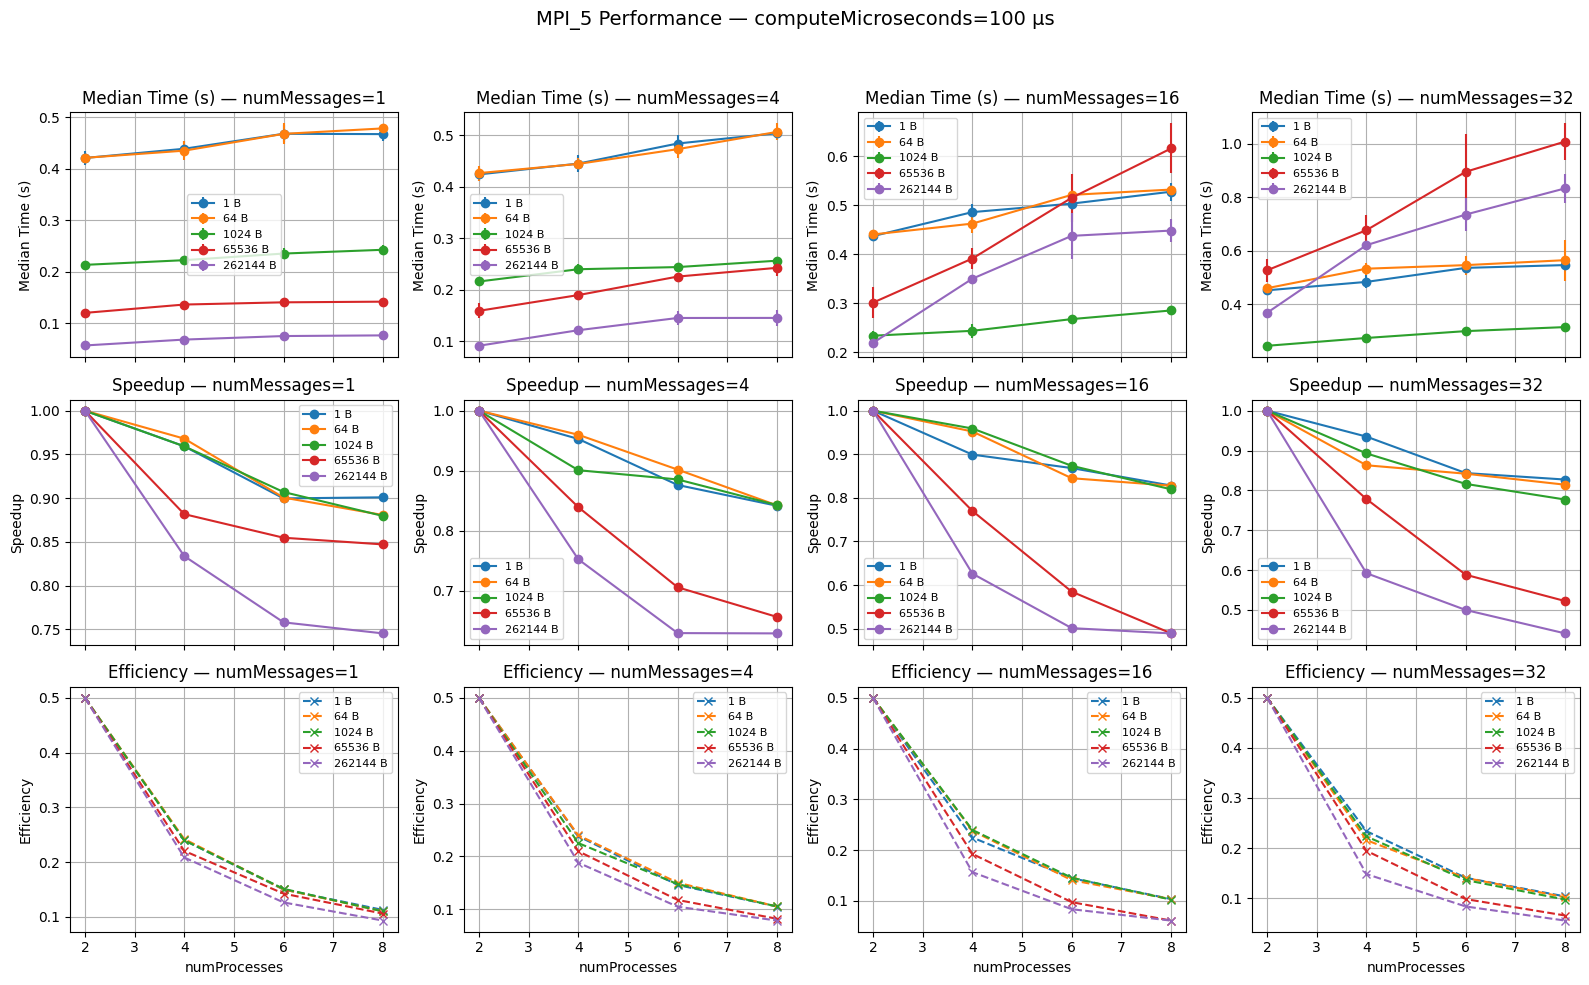

In [13]:
metrics = ["median", "speedup", "efficiency"]
metricLabels = {"median":"Median Time (s)", "speedup":"Speedup", "efficiency":"Efficiency"}

messageSizeList = sorted(perfFrame["messageSizeBytes"].unique())
computeMicroList = sorted(perfFrame["computeMicroseconds"].unique())
numMessagesList = sorted(perfFrame["numMessages"].unique())

for computeMicroVal in computeMicroList:
    filterByCompute = perfFrame[perfFrame["computeMicroseconds"] == computeMicroVal]
    if filterByCompute.empty:
        print(f"No data for computeMicroseconds={computeMicroVal}")
        continue

    numCols = max(1, len(numMessagesList))
    fig, axes = plt.subplots(len(metrics), numCols, figsize=(4 * numCols, 10), sharex=True)
    if len(metrics) == 1 and numCols == 1:
        axes2d = np.array([[axes]])
    elif len(metrics) == 1:
        axes2d = np.array([axes])
    elif numCols == 1:
        axes2d = np.array([[ax] for ax in axes])
    else:
        axes2d = axes

    for colIdx, numMessagesVal in enumerate(numMessagesList):
        for rowIdx, metric in enumerate(metrics):
            ax = axes2d[rowIdx][colIdx]
            subForMessages = filterByCompute[filterByCompute["numMessages"] == numMessagesVal]
            if subForMessages.empty:
                ax.text(0.5, 0.5, "no data", ha="center", va="center")
                ax.set_title(f"numMessages={numMessagesVal}")
                ax.grid(True)
                continue

            for messageSizeVal in messageSizeList:
                subFrame = subForMessages[subForMessages["messageSizeBytes"] == messageSizeVal].sort_values("numProcesses")
                if subFrame.empty:
                    continue
                x = subFrame["numProcesses"].values
                y = subFrame[metric].values
                labelStr = f"{messageSizeVal} B"
                if metric == "median":
                    yerr = subFrame["std"].values
                    ax.errorbar(x, y, yerr=yerr, marker='o', linestyle='-', label=labelStr)
                else:
                    linestyle = '-' if metric == 'speedup' else '--'
                    markerStyle = 'o' if metric == 'speedup' else 'x'
                    ax.plot(x, y, marker=markerStyle, linestyle=linestyle, label=labelStr)

            ax.set_title(f"{metricLabels[metric]} — numMessages={numMessagesVal}")
            if rowIdx == len(metrics) - 1:
                ax.set_xlabel("numProcesses")
            ax.set_ylabel(metricLabels[metric])
            ax.grid(True)
            ax.legend(fontsize=8)

    plt.suptitle(f"MPI_5 Performance — computeMicroseconds={computeMicroVal} µs", fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()


In [14]:
summaryRows = []
for (messageSizeVal, numMessagesVal, computeMicroVal), sub in perfFrame.groupby(["messageSizeBytes","numMessages","computeMicroseconds"]):
    if sub.empty:
        continue
    maxSpeedup = sub["speedup"].max()
    argMax = sub.loc[sub["speedup"].idxmax()]
    bestProcs = int(argMax["numProcesses"])
    effAtBest = float(argMax["efficiency"])
    medianAtTwo = sub.loc[sub["numProcesses"]==2, "median"]
    medianAtTwo = float(medianAtTwo.values[0]) if not medianAtTwo.empty else np.nan
    summaryRows.append({
        "messageSizeBytes": messageSizeVal,
        "numMessages": numMessagesVal,
        "computeMicroseconds": computeMicroVal,
        "bestNumProcesses": bestProcs,
        "maxSpeedup": maxSpeedup,
        "efficiencyAtBest": effAtBest,
        "medianTime2Proc": medianAtTwo
    })
summaryFrame = pd.DataFrame(summaryRows).sort_values(["computeMicroseconds","numMessages","messageSizeBytes"])
display(summaryFrame)


,messageSizeBytes,numMessages,computeMicroseconds,bestNumProcesses,maxSpeedup,efficiencyAtBest,medianTime2Proc
0,1,1,10,2,1.000000,0.500000,0.133996
12,64,1,10,2,1.000000,0.500000,0.134154
24,1024,1,10,2,1.000000,0.500000,0.068236
36,65536,1,10,2,1.000000,0.500000,0.047690
48,262144,1,10,2,1.000000,0.500000,0.027904
3,1,4,10,4,1.023787,0.255947,0.142029
15,64,4,10,2,1.000000,0.500000,0.137971
27,1024,4,10,2,1.000000,0.500000,0.071597
39,65536,4,10,2,1.000000,0.500000,0.098098
51,262144,4,10,2,1.000000,0.500000,0.060934
